In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pymatgen.io.cif import CifParser
from pymatgen.core.structure import Structure
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation
from smol.cofe import ClusterExpansion
from smol.moca import ClusterExpansionProcessor, CanonicalEnsemble, SGCanonicalEnsemble

## First create and fit a CE

In [2]:
# Open prim structure
with open('data/lno_prim.json', 'r') as f:
    lno_prim = Structure.from_dict(json.load(f))
    
# Open fitting data
with open('data/lno_fitting_data.json', 'r') as f:
    lno_data = [(Structure.from_dict(x['s']), x['toten']) for x in json.load(f)]
    
ce = ClusterExpansion.from_radii(structure=lno_prim,
                                 radii={2: 5, 3: 4.1},
                                 ltol=0.15, stol=0.2, angle_tol=5,
                                 supercell_size='O2-',
                                 data=lno_data,
                                 basis='sinusoid',
                                 orthonormal=True)
ce.fit()

## Now Create a Processor
#### Think of this as the old ClusterSuperCell. A Processor essentially computes correlations, energy, or changes of them for a single supercell size.

In [3]:
# Create a supercell matrix
sc_matrix = np.array([[3, 0, 0],
                      [0, 2, 0],
                      [0, 0, 1]])

# Create the processor
processor = ClusterExpansionProcessor(ce, sc_matrix)

### Create a test structure to use some of the processor functionality.
You rarely need to directly use the processor. You will use it to create an ensemble, and the ensemble will use it for MC

In [4]:
supercell = lno_prim.copy()
supercell.make_supercell(sc_matrix)
odt = OrderDisorderedStructureTransformation()
test_struct = odt.apply_transformation(supercell)

## Using a Canonical Ensemble

In [5]:
# Create the ensemble
censemble = CanonicalEnsemble(processor,
                              temperature=3000,
                              save_interval=200,  # How many steps to take between saved samples
                              initial_occupancy=None  # an initial occupancy can be optionally provided
                             )
# Run the ensemble
censemble.run(100000)

### Look at the ensemble current state properties

In [6]:
print(f'Fraction of succesfull steps {censemble.accepted_steps/censemble.current_step}')
print(f'The current step energy is {censemble.energy} eV')
print(f'The minimum energy in trajectory is {censemble.minimum_energy} eV')

# You can get the minimum energy structure and current structure
curr_s = censemble.current_structure
min_s = censemble.minimum_energy_structure

Fraction of succesfull steps 0.82721
The current step energy is -207.04104770332793 eV
The minimum energy in trajectory is -207.17194191640937 eV


### Look at trajectory data
Data is stored as a list of dictionaries for each sampled step in ensemble.data

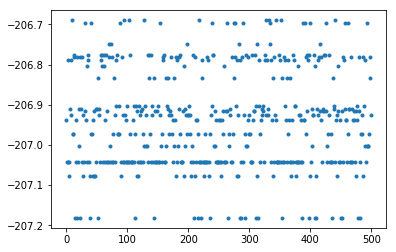

In [35]:
# Plot the energy trajectory
plt.plot([d['energy'] for d in censemble.data], '.')

# save the data
# censemble.dump('canonical1000.json')

#### Continuing or reseting the MC trajectory

In [ ]:
# You can continue the MC trajectory simmply by calling run again
censemble.run(100)  # this will append new data

# If you want to start from scratch
censemble.reset()  # this will delete data, and reset the ensemble to its initial state
# Now you can start a fresh run
censemble.run(100)